In [369]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ast import literal_eval

In [370]:
uot = pd.read_csv('enriched_work_orders_uot.csv').set_index('wonum') # (0.99, 0.75)
cossim = pd.read_csv('enriched_work_orders_cossim.csv').set_index('wonum')
gt = pd.read_csv('enriched_work_orders_with_manual_validation.csv').set_index('wonum')

In [371]:
uot = uot[['matched_component', 'match_score']]
cossim = cossim[['matched_component', 'match_score']]

gt = gt[['component_expert_selected']]
selection_map = gt['component_expert_selected'].fillna('').apply(len) > 0.0

uot = uot.loc[selection_map.index]
cossim = cossim.loc[selection_map.index]

cossim

,matched_component,match_score
wonum,,
96827,"['Filter, Control Air Supply: Clogged', 'Filte...","[0.4589855372905731, 0.37524399161338806, 0.34..."
96824,"['Filter, Control Air Supply: Clogged', 'Filte...","[0.4568450450897217, 0.3740607798099518, 0.343..."
112409,"['Filter, Control Air Supply: Clogged', 'Filte...","[0.47902363538742065, 0.42801329493522644, 0.3..."
112410,"['Filter, Control Air Supply: Clogged', 'Filte...","[0.47902363538742065, 0.42801329493522644, 0.3..."
70068,"['Filter, Control Air Supply: Clogged', 'Filte...","[0.501445472240448, 0.4537651836872101, 0.4217..."
...,...,...
7145,['Chiller Instrumentation and Control Devices:...,"[0.6571574807167053, 0.6374980807304382, 0.635..."
72681,['Chiller Instrumentation and Control Devices:...,"[0.6067287921905518, 0.6047133803367615, 0.565..."
78226,['Chiller Instrumentation and Control Devices:...,"[0.5582799911499023, 0.5399601459503174, 0.526..."


In [372]:
gt = gt.fillna('[]')

def unpack_match_list(df, col):
    df[[f'{col}_1', f'{col}_2', f'{col}_3']] = pd.DataFrame(df[col].apply(lambda x: literal_eval(x)).tolist(), index=df.index)
    return df

for col in ['matched_component', 'match_score']:
    cossim = unpack_match_list(cossim, col)
    uot = unpack_match_list(uot, col)

In [373]:
results = {}
threshold_ls = np.arange(0, 1.05, 0.05)

for method in ['cossim', 'uot']:
    if method == 'cossim': method_df = cossim.copy()
    else: method_df = uot.copy()

    results[method] = np.zeros((len(threshold_ls),4))

    match = pd.DataFrame([[False, False, False] for _ in range(len(gt[selection_map]))], index=gt[selection_map].index, columns=[i+1 for i in range(3)])
    for i, row in gt[selection_map].iterrows():
        match.loc[i, 1] = (method_df.loc[i, 'matched_component_1'].startswith(row['component_expert_selected']))
        match.loc[i, 2] = (method_df.loc[i, 'matched_component_2'].startswith(row['component_expert_selected']))
        match.loc[i, 3] = (method_df.loc[i, 'matched_component_3'].startswith(row['component_expert_selected']))

    for j, t in enumerate(threshold_ls):
        match[1] = match[1].where(uot['match_score_1'] >= t).fillna(0)
        match[2] = match[2].where(uot['match_score_2'] >= t).fillna(0)
        match[3] = match[3].where(uot['match_score_3'] >= t).fillna(0)

        results[method][j] = [match[1].mean(), match[2].mean(), match[3].mean(), (match.sum(axis=1) > 0.0).mean()]

/var/folders/zq/55p5bh3x1zb26857lp_z8m700000gn/T/ipykernel_55477/3543961236.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  match[3] = match[3].where(uot['match_score_3'] >= t).fillna(0)
/var/folders/zq/55p5bh3x1zb26857lp_z8m700000gn/T/ipykernel_55477/3543961236.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  match[2] = match[2].where(uot['match_score_2'] >= t).fillna(0)
/var/folders/zq/55p5bh3x1zb26857lp_z8m700000gn/T/ipykernel_55477/3543961236.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and w

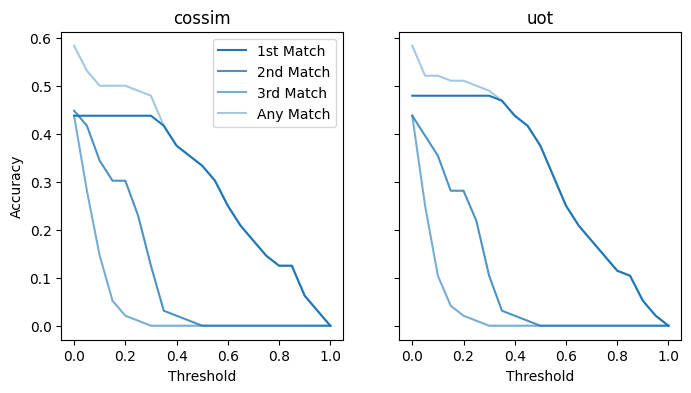

In [374]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(8,4))

labels = ['1st Match', '2nd Match', '3rd Match', 'Any Match']
alphas = [1.0, 0.8, 0.6, 0.4]

for i, col in enumerate(results['cossim'].T):
    axs[0].plot(threshold_ls, col, label=labels[i], alpha=alphas[i], color='tab:blue')
axs[0].set_title('cossim')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Threshold')

for i, col in enumerate(results['uot'].T):
    axs[1].plot(threshold_ls, col, label=labels[i], alpha=alphas[i], color='tab:blue')
axs[1].set_title('uot')
axs[1].set_xlabel('Threshold')

axs[0].legend()